In [1]:
# core libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Spark for loading clean data
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, year, month, col

# Metrics for evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# statsmodels for diagnostics


In [3]:
# 1. Start Spark
spark = SparkSession.builder \
    .appName("PlotForecast") \
    .config("spark.sql.shuffle.partitions", "50") \
    .getOrCreate()

# 2. Read cleaned street-level Parquet
hdfs_path = "hdfs://localhost:9000/user/yashwanthreddy/crime/clean/street"
df = spark.read.parquet(hdfs_path)
df = df.withColumn("date", to_date(col("date")))

# 3. Aggregate to monthly counts
monthly = (
    df.groupBy(year("date").alias("year"), month("date").alias("month"))
      .count()
      .orderBy("year", "month")
      .toPandas()
)

# 4. Build a proper datetime index
monthly["date"] = pd.to_datetime(
    dict(year=monthly["year"], month=monthly["month"], day=1)
)
monthly.set_index("date", inplace=True)
ts = monthly["count"].sort_index()

# Clean up Spark
spark.stop()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/09 20:08:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/09 20:08:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [7]:
# 1. Load forecast from CSV (generated earlier)
fc = pd.read_csv("output/forecast.csv", index_col=0, parse_dates=True)

# 2. Load the fitted ARIMA model
with open("output/arima_model.pkl", "rb") as f:
    arima_model = pickle.load(f)


In [9]:
# 1. Re-forecast using the loaded model for consistency
steps = len(fc)
model_fc = arima_model.get_forecast(steps=steps)
model_fc_df = model_fc.summary_frame()  # contains mean, ci_lower, ci_upper

# 2. Split historical series into train/test
train, test = ts[:-steps], ts[-steps:]

# 3. Evaluation metrics
y_true = test.values
y_pred = model_fc_df["mean"].values
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)

print(f"Forecast Performance → RMSE: {rmse:.2f}, MAE: {mae:.2f}")


Forecast Performance → RMSE: 16830.41, MAE: 13426.52


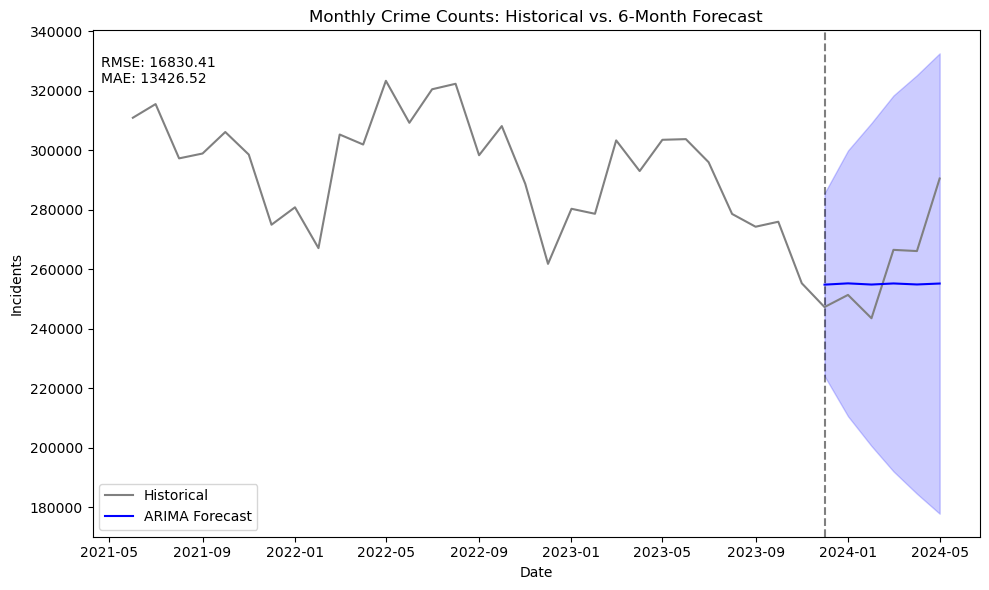

In [13]:
plt.figure(figsize=(10,6))
# Historical
plt.plot(ts.index, ts.values, label="Historical", color="gray")
# Train/Test split line
plt.axvline(x=test.index[0], color="black", linestyle="--", alpha=0.5)
# Model forecast
plt.plot(model_fc_df.index, model_fc_df["mean"], label="ARIMA Forecast", color="blue")
plt.fill_between(
    model_fc_df.index,
    model_fc_df["mean_ci_lower"],
    model_fc_df["mean_ci_upper"],
    color="blue", alpha=0.2
)
# Annotate metrics
plt.text(
    0.01, 0.95,
    f"RMSE: {rmse:.2f}\nMAE: {mae:.2f}",
    transform=plt.gca().transAxes,
    verticalalignment="top"
)

plt.title("Monthly Crime Counts: Historical vs. 6-Month Forecast")
plt.xlabel("Date")
plt.ylabel("Incidents")
plt.legend()
plt.tight_layout()
plt.savefig("output/forecast_comparison.png")
plt.show()


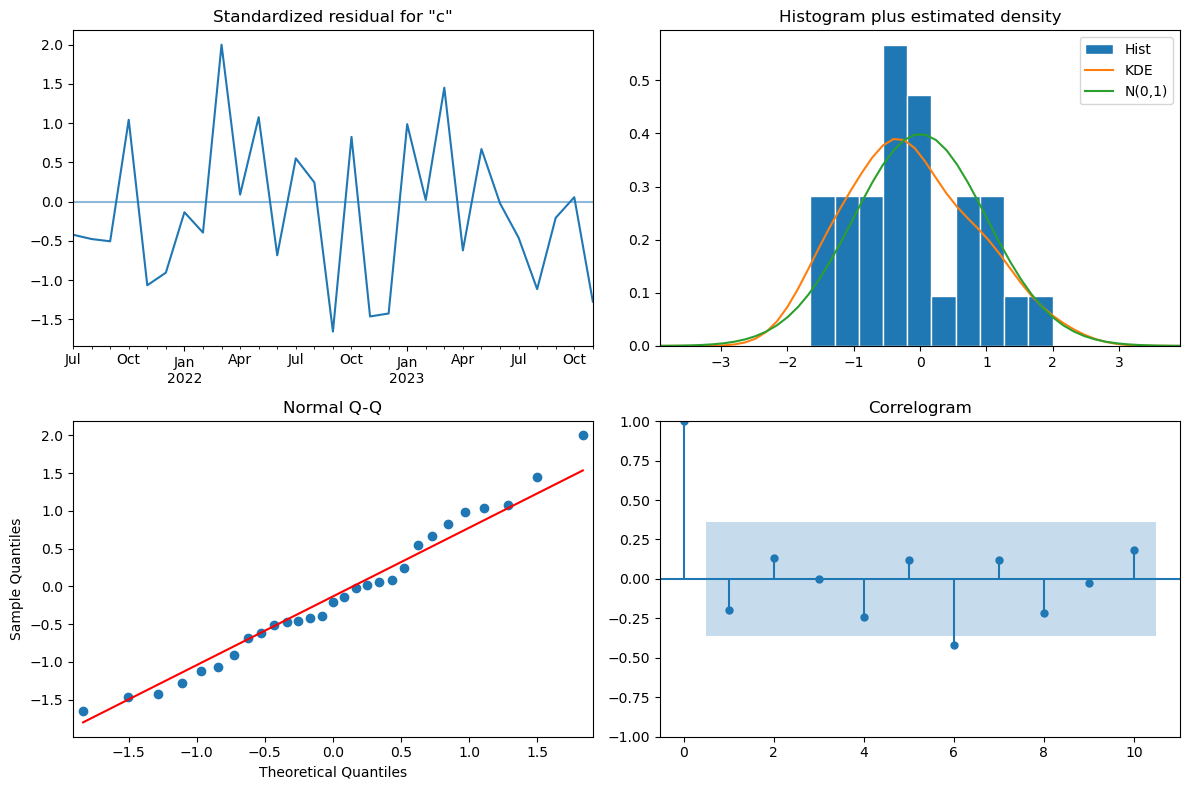

In [17]:
# statsmodels provides a built-in diagnostics plot
fig = arima_model.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
fig.savefig("output/arima_diagnostics.png")
plt.show()
